In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Set random seed
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# "Starter" hyperparameters
input_size = 28 * 28  # since MNIST images are 28x28 pixels
hidden_size = 128 # number of features in the hidden layer
num_classes = 10 # output classes (digits 0-9)
num_epochs = 5 # number of epochs to train the model
batch_size = 64 # number of samples per batch
learning_rate = 0.001 # learning rate for the optimizer

In [4]:
# # A data preprocessing pipeline specifically for MNIST
# # These values in transforms.Normalize are MNIST's dataset-wide mean and std (computed over training set).
# # This helps models train faster and converge better.
# # But you can also un-comment the normalise out and compare the performance.
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

# Load training data
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# Load test data
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Feature extraction
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
        )

        # Classification head
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # Feature extraction
        x = self.conv_block(x)
        
        # Flatten the output for the fully connected layers
        x = self.flatten(x)
        
        # Fully connected layers
        x = self.dropout(x)
        # You can also try without dropout or after fc1 or both for comparison
        x = self.fc1(x)
        # x = self.dropout(x)  # You can also try different rate of dropout
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

In [6]:
# Instantiate the model
model = CNN().to(device)
print(model)

CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 421,642


In [8]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, dataloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx + 1}/{len(dataloader)}, Loss: {running_loss/100:.4f}, Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
    
    return 100. * correct / total

def test(model, dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(dataloader)
    print(f'Test Loss: {avg_loss:.4f}, Test Acc: {accuracy:.2f}%')
    
    return accuracy

In [9]:
# Training loop
train_accuracies = []
test_accuracies = []
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    train_acc = train(model, train_loader, criterion, optimizer, epoch)
    test_acc = test(model, test_loader, criterion)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f'Epoch {epoch} completed')

total_time = time.time() - start_time
print(f'Training completed in {total_time:.2f} seconds')

Epoch: 1, Batch: 100/938, Loss: 0.7970, Acc: 75.27%
Epoch: 1, Batch: 200/938, Loss: 0.2561, Acc: 83.86%
Epoch: 1, Batch: 300/938, Loss: 0.1463, Acc: 87.76%
Epoch: 1, Batch: 400/938, Loss: 0.1200, Acc: 89.86%
Epoch: 1, Batch: 500/938, Loss: 0.1241, Acc: 91.16%
Epoch: 1, Batch: 600/938, Loss: 0.0907, Acc: 92.15%
Epoch: 1, Batch: 700/938, Loss: 0.0934, Acc: 92.86%
Epoch: 1, Batch: 800/938, Loss: 0.0872, Acc: 93.41%
Epoch: 1, Batch: 900/938, Loss: 0.0694, Acc: 93.90%
Test Loss: 0.0608, Test Acc: 97.99%
Epoch 1 completed
Epoch: 2, Batch: 100/938, Loss: 0.0692, Acc: 97.75%
Epoch: 2, Batch: 200/938, Loss: 0.0640, Acc: 97.88%
Epoch: 2, Batch: 300/938, Loss: 0.0614, Acc: 97.98%
Epoch: 2, Batch: 400/938, Loss: 0.0562, Acc: 98.09%
Epoch: 2, Batch: 500/938, Loss: 0.0600, Acc: 98.13%
Epoch: 2, Batch: 600/938, Loss: 0.0632, Acc: 98.12%
Epoch: 2, Batch: 700/938, Loss: 0.0546, Acc: 98.14%
Epoch: 2, Batch: 800/938, Loss: 0.0584, Acc: 98.13%
Epoch: 2, Batch: 900/938, Loss: 0.0474, Acc: 98.16%
Test Loss:

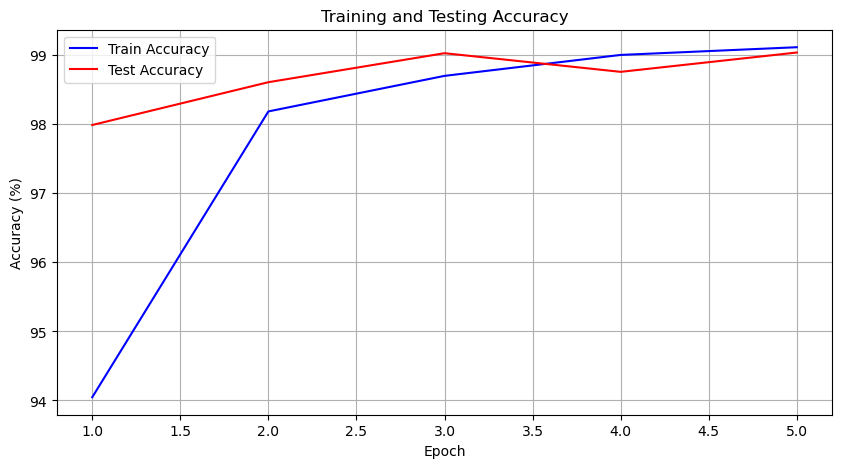

In [10]:
# Plot training and testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, 'r-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()

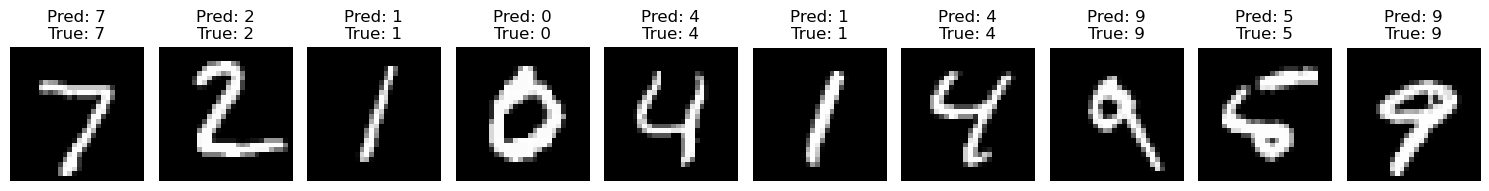

In [11]:
# Visualize some predictions
def show_predictions(model, dataloader, n=10):
    model.eval()
    examples = iter(dataloader)
    images, labels = next(examples)
    
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i][0].cpu().numpy(), cmap='gray')
        plt.title(f'Pred: {predicted[i].item()}\nTrue: {labels[i].item()}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader)

In [12]:
# Visualize filters/feature maps
def visualize_layer_outputs(model, dataloader, img_index=0):
    dataiter = iter(dataloader)
    images, _ = next(dataiter)

    if img_index >= images.size(0):
        raise ValueError(f"img_index {img_index} out of range for batch size {images.size(0)}")

    img = images[img_index:img_index+1].to(device)  # Get the specified image
    
    # Extract feature maps from first conv layer
    model.eval()
    with torch.no_grad():
        # Forward pass through first conv layer
        x = model.conv_block[0](img)   # Conv2d(1, 32, ...)
        x = F.relu(x)
        activation = model.conv_block[2](x)  # MaxPool2d(2, 2)
        
    # Visualize the feature maps
    fig = plt.figure(figsize=(20, 10))
    for i in range(min(32, activation.size(1))):  # Show up to 32 feature maps
        ax = fig.add_subplot(4, 8, i+1)
        ax.imshow(activation[0, i].cpu().numpy(), cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i}')
    
    plt.tight_layout()
    plt.show()

    # Show the original image for reference
    plt.figure(figsize=(2, 2))
    plt.imshow(images[img_index][0].numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

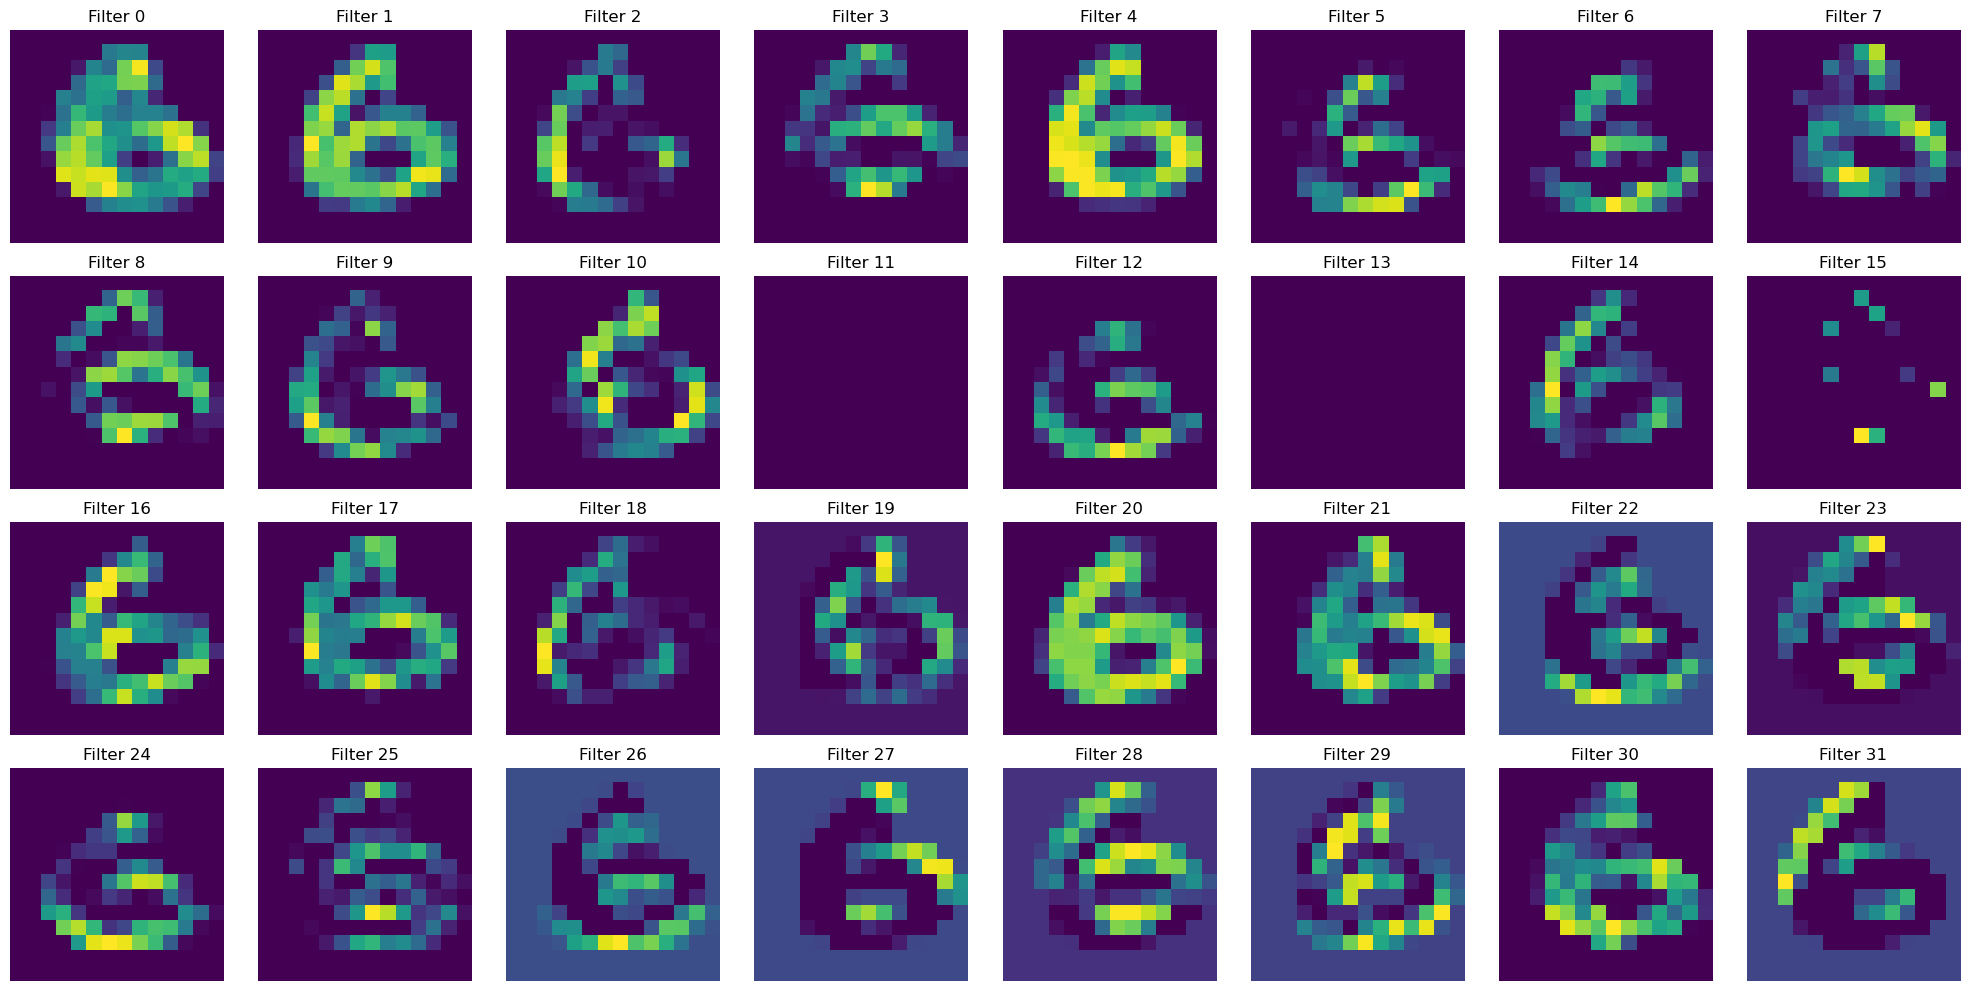

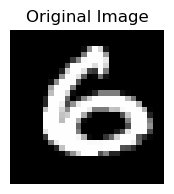

In [13]:
# You can visualize the feature maps of any image in the batch
visualize_layer_outputs(model, train_loader, img_index=42)

In [14]:
# Save the model
torch.save(model.state_dict(), 'cnn_mnist_model.pth')
print("Model saved.")

# Example of loading the model
def load_model():
    loaded_model = CNN().to(device)
    loaded_model.load_state_dict(torch.load('cnn_mnist_model.pth'))
    loaded_model.eval()
    return loaded_model

# loaded_model = load_model()

Model saved.


In [15]:
import torchinfo
torchinfo.summary(model, input_size=(1, 1, 28, 28), device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 7, 7]             --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           18,496
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 64, 7, 7]             --
├─Flatten: 1-2                           [1, 3136]                 --
├─Dropout: 1-3                           [1, 3136]                 --
├─Linear: 1-4                            [1, 128]                  401,536
├─Linear: 1-5                            [1, 10]                   1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
